In [1]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, Utils
from SimPEG import DataMisfit, Inversion, Regularization, Problem, Survey
from SimPEG.Utils import mkvc
import numpy as np
import scipy as sp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create simple mesh with topo
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 7), (3.5, 1), (2, 5)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-2]

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
                  dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, 0)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-60., 60., 4)
yr = np.linspace(-30., 30., 3)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = -np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1]

# XYZ point locations
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]

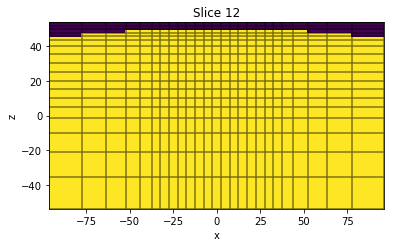

In [3]:
# Show active model and obs
m = np.ones(nC)

model = actvMap*m

axs = plt.subplot()
mesh.plotSlice(model, normal='Y', ax=axs, ind=int(mesh.vnC[1]/2), grid=True)
axs.set_aspect('equal')

In [4]:
# Find the index of the 1D model associated with each receivers
inCell = Utils.closestPoints(mesh, rxLoc).tolist()

model = model.reshape(mesh.vnC, order='F')

ijkTop = []
subxy = []
for sub in inCell:
    
    ij = np.unravel_index(sub, mesh.vnC, 'F')[:2]
    
    # Fetch the first active
    ijk = np.r_[ij, np.argmax(model[ij[0],ij[1],:]<1)]
    ijkTop += [ijk]
    subxy += [np.ravel_multi_index(ij,dims=mesh.vnC[:2], order='F')]

In [5]:
# For tester, paint different value in model
for col in ijkTop:
    model[col[0], col[1], :col[2]] = 0

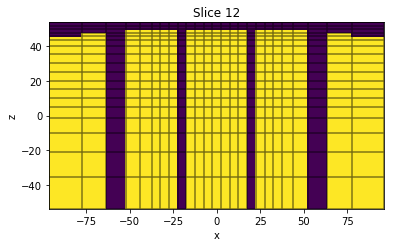

In [6]:
axs = plt.subplot()
mesh.plotSlice(model, normal='Y', ax=axs, ind=int(mesh.vnC[1]/2), grid=True)
axs.set_aspect('equal')

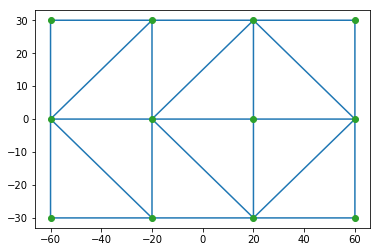

In [7]:
# Create Delauny triangulation to find closest stations
tri = sp.spatial.Delaunay(rxLoc[:,:2])
plt.triplot(rxLoc[:,0], rxLoc[:,1], tri.simplices)
plt.plot(rxLoc[:,0], rxLoc[:,1], 'o')
plt.show()

In [10]:
# Split the triangulation into connections
edges = np.r_[tri.simplices[:,:2],tri.simplices[:,1:],tri.simplices[:,[0,2]]]

# Sort and keep uniques
edges = np.sort(edges, axis=1)
edges = np.unique(edges[np.argsort(edges[:,0]),:], axis=0)


In [44]:
# Create 2D operator
nRow = edges.shape[0]
stn, count = np.unique(edges[:,0], return_counts = True)

col = []
row = []
val = []
for ii in range(nRow):
    row += [edges[ii,0], edges[ii,0]]
    col += [edges[ii,0], edges[ii,1]]
    
    scale = count[stn==edges[ii,0]][0]
    val += [-1./scale, 1./scale]
    
D = sp.sparse.csr_matrix((val, (row, col)), shape=(nRow, rxLoc.shape[0]))

# Expand to 3D columns
Grad = sp.sparse.kron(Utils.speye(mesh.vnC[2]), D)
# Normalize by 

# Create projector from 1D to 3D
row = range(rxLoc.shape[0])
P = sp.sparse.csr_matrix((np.ones(rxLoc.shape[0]), (row, subxy)), shape=(rxLoc.shape[0], mesh.vnC[0]*mesh.vnC[1]))
P = sp.sparse.kron(Utils.speye(mesh.vnC[2]), P)

In [45]:
# For tester, paint different value in model
for col in ijkTop[5:7]:
    model[col[0], col[1], :col[2]] = 1

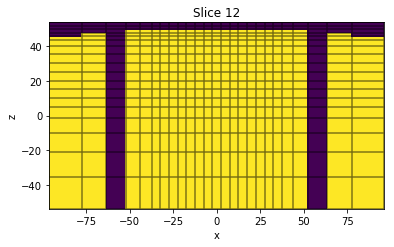

In [46]:
axs = plt.subplot()
mesh.plotSlice(model, normal='Y', ax=axs, ind=int(mesh.vnC[1]/2), grid=True)
axs.set_aspect('equal')



In [49]:
Grad.max()

1.0

In [50]:
mDeriv = P.T*Grad.T*Grad*P*mkvc(model)

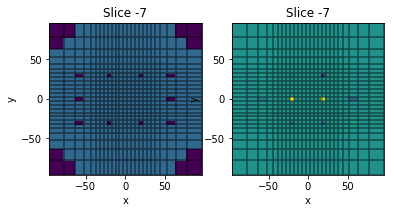

In [52]:
axs = plt.subplot(1,2,1)
mesh.plotSlice(model, normal='Z', ax=axs, ind=-7, clim=[0,3], grid=True)
axs.set_aspect('equal')
axs = plt.subplot(1,2,2)
mesh.plotSlice(mDeriv, normal='Z', ax=axs, ind=-7, clim=[-1,1],grid=True)
axs.set_aspect('equal')

In [53]:
Grad.T*Grad*P*mkvc(model)

array([ 0.        , -0.33333333, -0.38888889,  0.125     , -0.22222222,
        1.01388889,  0.90277778, -0.375     ,  0.11111111, -0.11111111,
       -0.72222222,  0.        ,  0.        , -0.33333333, -0.38888889,
        0.125     , -0.22222222,  1.01388889,  0.90277778, -0.375     ,
        0.11111111, -0.11111111, -0.72222222,  0.        ,  0.        ,
       -0.33333333, -0.38888889,  0.125     , -0.22222222,  1.01388889,
        0.90277778, -0.375     ,  0.11111111, -0.11111111, -0.72222222,
        0.        ,  0.        , -0.33333333, -0.38888889,  0.125     ,
       -0.22222222,  1.01388889,  0.90277778, -0.375     ,  0.11111111,
       -0.11111111, -0.72222222,  0.        ,  0.        , -0.33333333,
       -0.38888889,  0.125     , -0.22222222,  1.01388889,  0.90277778,
       -0.375     ,  0.11111111, -0.11111111, -0.72222222,  0.        ,
        0.        , -0.33333333, -0.38888889,  0.125     , -0.22222222,
        1.01388889,  0.90277778, -0.375     ,  0.11111111, -0.11